In [659]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, math

In [660]:
def plot_figs(imgs, titles=None, max_col=4):
    """
    Plots list of images in a grid. 
    -----
    args imgs: list of images.
    args titles: list of titles, defaults to None.
    args max_col: number of column in the grid, defaults to 4.
    -----
    return: None.
    """
    n = len(imgs)
    
    # Each plot can hold up to 8 images.
    rows_per_set = 8 // max_col 
    fig_per_set = rows_per_set * max_col
    sets = math.ceil(n / fig_per_set)
    
    for s in range(sets):
        # starting index of your set
        start = s * fig_per_set
        
        # compute the number of images and rows in the current set 
        subset_len = min(start+fig_per_set, n) - start
        nb_rows = math.ceil(subset_len / max_col)
        
        # set subplot map 
        subplot = "{}{}".format(nb_rows, max_col)
        plt.figure(figsize=(20, 4 * nb_rows))
        for i in range(subset_len):
            plt.subplot(int("{}{}".format(subplot, i+1)))
            if titles is not None: 
                plt.title(titles[start + i])
            else:
                plt.title(str(start + i + 1))
            plt.axis('off')
            plt.imshow(imgs[start + i], cmap='gray')
    plt.show()

In [661]:
def find_nearest_neighbor(sample, dataset, index=None):
    """
    Iterates through the dataset to return the nearest neighbor sample. 
    -----
    args sample: the reference sample. 
    args dataset: the dataset you are searching in, should be a list of items 
        with the same format as the sample.
    args index: if the sample is part of the dataset, set value to index of 
        sample within the dataset. Defaults to None. 
    -----
    return: index of the nn within the dataset, nn sample. 
    """
    l2_norms = []
    for i in range(len(dataset)):
        if i == index:
            l2_norms.append(float('inf'))
        else:
            l2_norms.append(np.linalg.norm(dataset[i] - sample, ord=2))
    min_index = np.argmin(l2_norms)
    return min_index, dataset[min_index]

In [662]:
def get_nn_same_class_metrics(X, Y):
    """
    Computes the number of samples in a dataset whose nearest neighbors is in the 
    same class. 
    -----
    args X: the dataset you are working with. 
    args Y: the corresponding classes of the dataset. 
    -----
    return: 
        - nb_same_class: (int) number of samples that are in the same class as its nn. 
        - fraction_same_class: (float) fraction of same class samples. 
    """
    NN_same_class = []
    for i in range(len(X)): 
        NN, _ = find_nearest_neighbor(X[i], X, i)
        if (Y[NN] == Y[i]): 
            NN_same_class.append(1) 
        else: 
            NN_same_class.append(0)
    nb_same_class = NN_same_class.count(1)
    frac_same_class = float(nb_same_class / len(X))
    
    return nb_same_class, frac_same_class

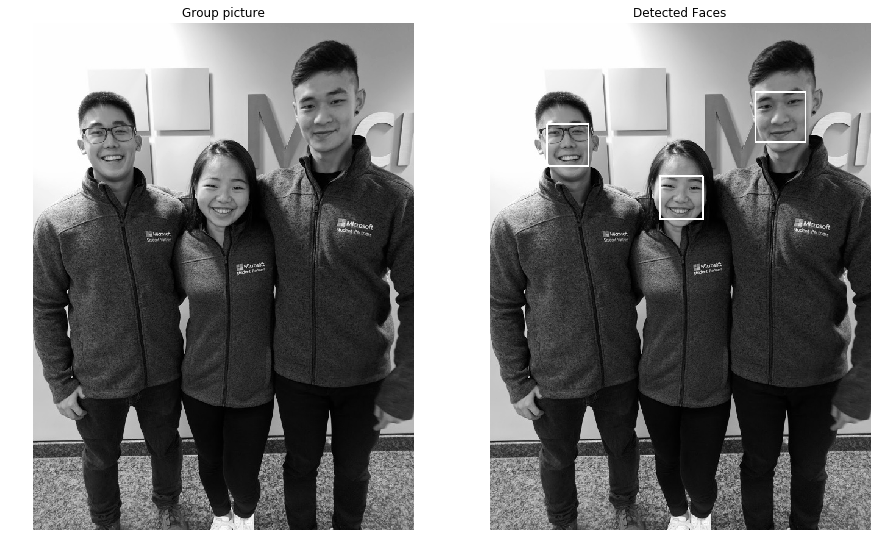

In [715]:
data_path = cv2.data.haarcascades
# face_front = cv2.CascadeClassifier( os.path.join(data_path, 'haarcascade_frontalface_default.xml') )
face_front = cv2.CascadeClassifier( './clf/lbpcascade_frontalface.xml')

group = cv2.imread('./group.jpeg', cv2.IMREAD_GRAYSCALE)
faces = face_front.detectMultiScale(group, 1.04, 2)

detected_group = group.copy()
for (x, y, w, h) in faces: 
    cv2.rectangle(detected_group, (x,y), (x+w, y+h), (255,0,0), 2)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.title("Group picture")
plt.imshow(group, cmap='gray'), plt.axis('off')

plt.subplot(122), plt.title("Detected Faces")
plt.imshow(detected_group, cmap='gray'), plt.axis('off')
plt.show()  

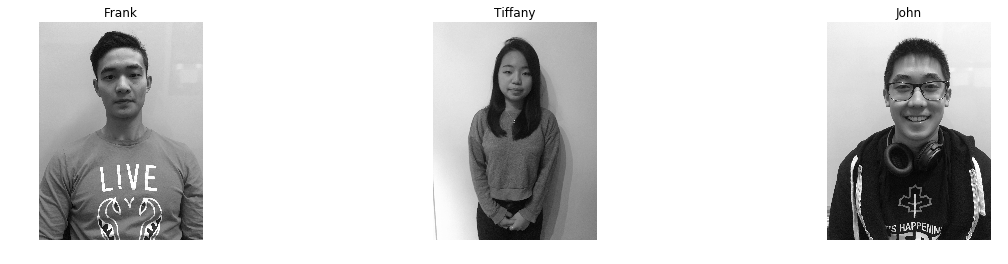

In [664]:
ds_path = './dataset/'

# Build dataset 
files = os.listdir(ds_path)
files = [file for file in files if file.endswith('.jpeg')]
files.sort()

imgs, Y_train = [], []

for file in files: 
    imgs.append(cv2.imread(ds_path + file, cv2.IMREAD_GRAYSCALE))
    Y_train.append(file.split('_')[0])

# Get class names 
cls = set(Y_train)

# Plot a sample from each class 
titles = []
sample_img = []
for c in cls: 
    idx = Y_train.index(c)
    titles.append(c)
    sample_img.append(imgs[idx])

plot_figs(sample_img, titles, max_col=3)

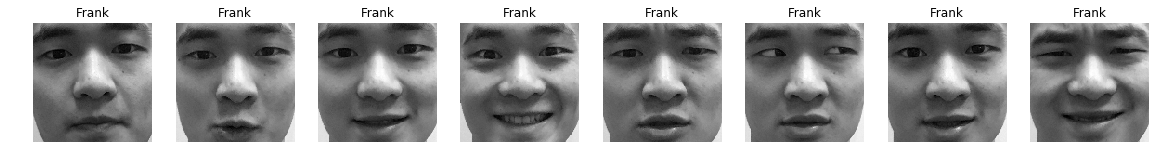

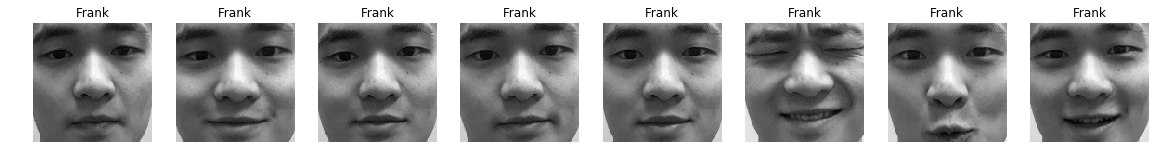

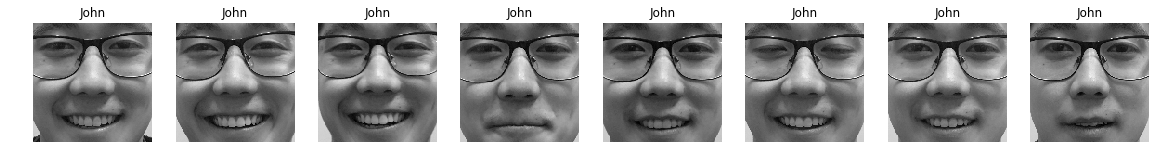

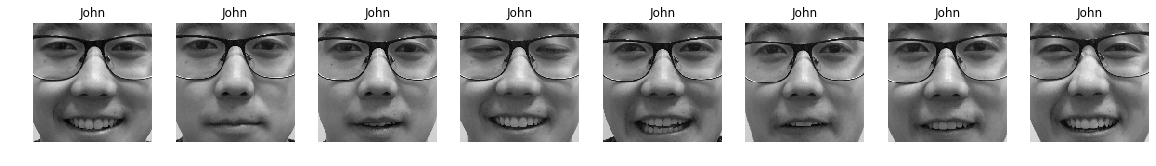

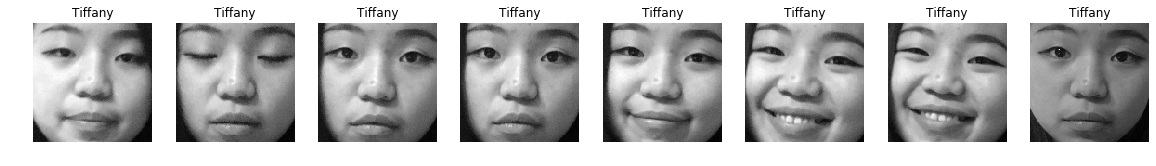

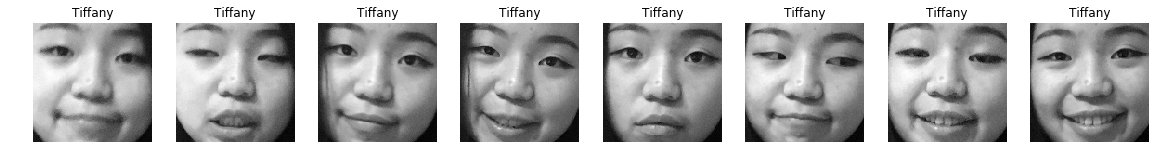

In [665]:
# Crop and resize images to only keep the faces
size = (128, 128)

X_train = []

for img in imgs: 
    face = face_front.detectMultiScale(img, 1.2, 2)
    x, y, w, h = face[0] # we know that there is only one face per training sample. 
    face_extract = img[y:y+h, x:x+w]
    face_extract = cv2.resize(face_extract, size) 
    X_train.append(face_extract)
    
plot_figs(X, Y, max_col=8)

#### Describe how you selected the images with respect to the conditions of the detection/classication methods

### PCA

In [666]:
X_train = np.array(X)
Y_train = Y
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


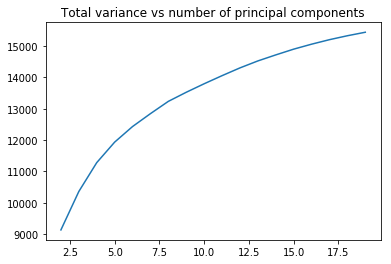

In [667]:
n_components = 20
component_list = list(range(2, n_components))
total_variance = []
for nb in component_list:
    pca = PCA(n_components=nb)
    pca.fit( X_train )
    variance = pca.explained_variance_
    total_variance.append(np.sum(variance))
    
plt.plot(component_list, total_variance)
plt.title('Total variance vs number of principal components')
plt.show()

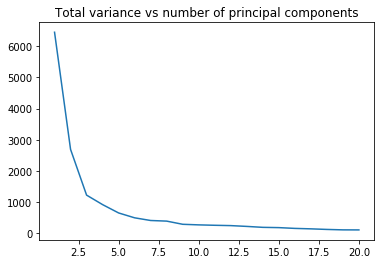

In [668]:
pca = PCA(n_components=n_components)
pca.fit( X_train )
variance = pca.explained_variance_

plt.plot(list(range(1, n_components + 1)), variance)
plt.title('Total variance vs number of principal components')
plt.show()

In [669]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform( X_train )
X_train_pca = np.array(X_train_pca)

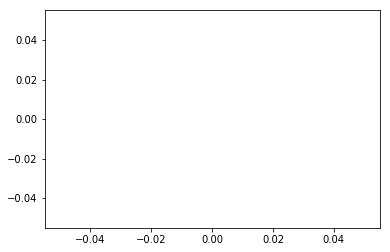

In [712]:
for c in cls: 
    x_cls = X_train_pca[ Y_train == c, :]
    plt.scatter(x_cls[:,0], x_cls[:,1])

plt.show()

In [671]:
nb_PCA, frac_PCA = get_nn_same_class_metrics(X_train_pca, Y_train)
nb_original, frac_original = get_nn_same_class_metrics(X_train, Y_train)

print("PCA: {} samples out of {} had the same class as its nearest neighbor, that is {}%."
          .format(nb_PCA, len(X_train_pca), frac_PCA * 100))
print("Original: {} samples out of {} had the same class as its nearest neighbor, that is {:.2f}%."
          .format(nb_original, len(X_train), frac_original * 100))

PCA: 48 samples out of 48 had the same class as its nearest neighbor, that is 100.0%.
Original: 48 samples out of 48 had the same class as its nearest neighbor, that is 100.00%.


/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/TiffanyWang/Documents/Assignments/compvision/lib/python3.7/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Face recognition results


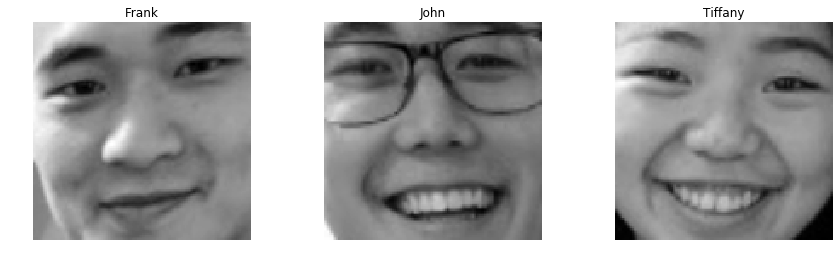

Corresponding class sample


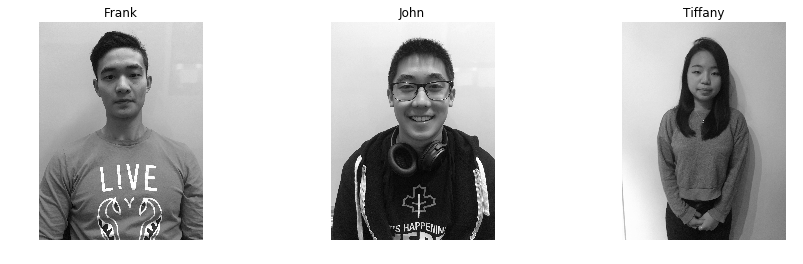

In [717]:
detected_faces = []
for (x, y, w, h) in faces: 
    extract = group[y:y+h, x:x+w]
    extract = cv2.resize(extract, size)
    detected_faces.append(extract)
detected_faces = np.array(detected_faces)
detected_faces = detected_faces.reshape(detected_faces.shape[0], -1)
detected_faces_std = scaler.fit_transform(detected_faces)
detected_faces_pca = pca.transform(detected_faces_std)
predictions = []
for face in detected_faces_pca: 
    idx, _ = find_nearest_neighbor(face, X_train_pca)
    predictions.append(Y_train[idx])

detected_faces = detected_faces.reshape(detected_faces.shape[0], size[0], size[0])

print("Face recognition results")
plot_figs(detected_faces, predictions)

print("Corresponding class sample")
samples = []
for c in predictions: 
    idx = Y_train.index(c)
    samples.append(imgs[idx])

plot_figs(samples, predictions)

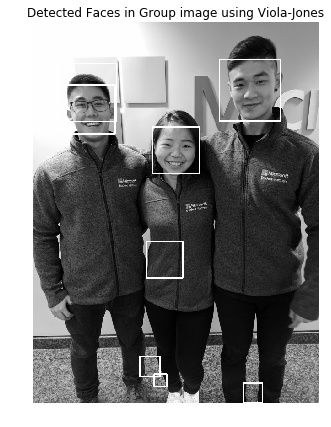

In [711]:
face_cascade = cv2.CascadeClassifier(data_path + 'haarcascade_frontalface_default.xml')

# Detect faces using Viola-Jones Haar Feature Classifier
group_vj = group.copy()

# Detect faces using Viola-Jones face detector
faces = face_cascade.detectMultiScale(group_vj, 1.04, 4)
for (x,y,w,h) in faces:
    cv2.rectangle(group_vj, (x,y), (x+w, y+h), (255,0,0), 2)

# Display images
plt.figure(figsize=(7,7))
plt.imshow(group_vj, cmap='gray')
plt.title("Detected Faces in Group image using Viola-Jones"), plt.axis('off')
plt.show()